In [1]:
execution_mode = 'full'

# Neural Network Model

As a third and last model, this chapter describes the implementation of a Neural Network as a classifier. The implementation will be done with the Python Deep Learning library Keras. The structure of the chapter will be the same as for the preceding two chapters.

## Table of Contents

- [Data Takeover](#Data-Takeover)
- [Neural Network Implementation](#Neural-Network-Implementation)
    - [Train/Test Split](#Train/Test-Split)
    - [Model Training](#Model-Training)
    - [General Observations](#General-Observations)
    - [Performance Measurement](#Performance-Measurement)
- [Summary](#Summary)
    - [Results Handover](#Results-Handover)

## Data Takeover

As the first step, the data from the preceding data preparation chapters have to be read as input for processing in this chapter.

In [2]:
import os
import pandas as pd
import bz2
import _pickle as cPickle

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

# Restore DataFrame with features from compressed pickle file
with bz2.BZ2File((os.path.join(
    path_goldstandard, 'labelled_feature_matrix_full.pkl')), 'rb') as file:
    df_attribute_with_sim_feature = cPickle.load(file)

df_labelled_feature_matrix.describe()

,coordinate_E_delta,coordinate_N_delta,corporate_full_delta,doi_delta,edition_delta,exactDate_delta,format_prefix_delta,format_postfix_delta,isbn_delta,ismn_delta,...,part_delta,person_100_delta,person_700_delta,person_245c_delta,pubinit_delta,scale_delta,ttlfull_245_delta,ttlfull_246_delta,volumes_delta,duplicates
count,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,...,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000,170340.000000
mean,-0.939094,-0.918521,-0.722431,-0.912460,-0.800944,0.547277,0.646425,0.649494,0.620758,-0.972326,...,-0.385987,-0.005908,-0.030070,0.509499,0.040912,-0.917802,0.713987,-0.843532,0.313381,0.394259
std,0.219312,0.330333,0.531579,0.343545,0.489194,0.221504,0.478081,0.378441,0.485191,0.190706,...,0.745796,0.804324,0.785492,0.547339,0.761979,0.336268,0.210059,0.438087,0.661196,0.488692
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.375000,0.000000,0.428571,0.000000,-1.000000,...,-1.000000,-0.500000,-0.500000,0.485444,-0.500000,-1.000000,0.528986,-1.000000,0.000000,0.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.500000,1.000000,1.000000,1.000000,-1.000000,...,-0.500000,-0.500000,-0.500000,0.581770,0.394180,-1.000000,0.625912,-1.000000,0.511111,0.000000
75%,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,0.750000,1.000000,1.000000,1.000000,-1.000000,...,0.000000,0.957778,0.668636,0.972222,0.866667,-1.000000,0.944145,-1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
print('Part of duplicates (1) and uniques (0) in units of [%]')
print(round(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100, 2))

Part of duplicates (1) and uniques (0) in units of [%]
0    60.57
1    39.43
Name: duplicates, dtype: float64


## Neural Network Implementation

The Neural Network implementation to be used will consist of two different architectures. The first architecture will implement a network with one and the second architecture will implement a network with two hidden layers. The accuracy scores of the two architectures will be compared and the best model will be taken to the summary chapter for comparison with the results of the models so far.

### Train/Test Split

The loaded data has to be split into two data subsets, one for training and a smaller one for testing data. The implementation below will use cross-validation. Therefore, a validation data subset will be done by the implementation and is not needed explicitly.

In [4]:
import classifier_fitting_funcs as cff

X_tr, _, X_te, y_tr, _, y_te, idx_tr, _, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        ,  0.84      , -1.        , -1.        ,
          1.        ,  1.        ,  1.        ,  1.        , -1.        ,
         -1.        , -1.        ,  0.91344156,  0.98947368,  1.        ,
         -1.        , -1.        ,  0.97195767, -1.        ,  1.        ],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.375     ,  0.        ,  0.11111111,  0.        , -1.        ,
         -1.        , -1.        ,  0.        , -0.5       , -0.5       ,
          0.42857143, -1.        ,  0.51524948, -1.        , -0.5       ],
        [ 0.125     ,  1.        ,  1.        , -1.        , -1.        ,
          0.75      ,  1.        ,  1.        ,  1.        , -1.        ,
         -1.        ,  1.        , -1.        ,  0.885     ,  0.9846723 ,
          0.98666667,  1.        ,  0.98412698,  0.84385965,  1.        ],
        [ 0.125     ,  1.        ,  0.97777778, -1.        , -1.        ,
          0.75      ,  1.        , 

In [5]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)
print('The test data set holds {:d} records of uniques and {:d} records of duplicates.'.format(
    len(y_te[y_te==0]), len(y_te[y_te==1])))

(136272, 20) (136272,) (34068, 20) (34068,)
The test data set holds 20636 records of uniques and 13432 records of duplicates.


### Model Training

For more flexibility in the implementation, a special function has been written that takes the parameter dictionary of the grid space as argument and builds up the layers of the network according to the input. The network architecture can be chosen with a first hidden layer with dropout, an optional second hidden and an output layer. The code of the following function does the construction job and returns the required model to the calling code.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

def build_and_compile_nn(params):
    # Input layer
    hidden1 = Dense(
#        12, # Number of units for hidden layer
        params['number_of_hidden1_layers'], # Number of units for hidden layer
        input_shape=(X_tr.shape[1],),
        activation='relu',
        kernel_initializer=VarianceScaling(scale=2.0, seed=0),
        kernel_regularizer=l2(params['l2_alpha']),
        bias_initializer='zeros'
    )

    # With dropout layer
    dropout = Dropout(
        rate=params['dropout_rate'],
        seed=0
    )

    if params['number_of_hidden2_layers'] > 0 :
        hidden2 = Dense(
    #        12, # Number of units for hidden layer
            params['number_of_hidden2_layers'], # Number of units for hidden layer
            input_shape=(params['number_of_hidden1_layers'],),
            activation='relu',
            kernel_initializer=VarianceScaling(scale=2.0, seed=0),
            kernel_regularizer=l2(params['l2_alpha']),
            bias_initializer='zeros'
        )

    # Output layer
    output = Dense(
        2,
    #    activation='sigmoid', # Bring out 0 or 1 values
        activation='softmax', # Bring out 0 or 1 values
        kernel_initializer=VarianceScaling(scale=1, seed=0),
        kernel_regularizer=l2(params['l2_alpha']),
        bias_initializer='zeros'
    )

    # Create model with sequential API
    model = Sequential()
    model.add( hidden1 ) # Hidden layer 1
    model.add( dropout ) # Dropout
    if params['number_of_hidden2_layers'] > 0 :
        model.add( hidden2 ) # Hidden layer 2
    model.add( output ) # Output layer

    # The optimizer is to be SGD
    #sgd = SGD(lr=params['sgd_learnrate'])
    model_optimizer = Adam(lr=params['sgd_learnrate'])

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=model_optimizer,
        metrics=['accuracy']
    #    metrics=['categorical_accuracy']
    )

    return model

Using TensorFlow backend.


The accuracy score will be plotted for each model to be calculated. The repeatedly used plotting function has been implemented in the separate function below.

In [7]:
import matplotlib.pyplot as plt

def plot_result(history, params):
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.title(r'Bilayer neural network with lr = {} and $\alpha=${}'.format(
        params['sgd_learnrate'], params['l2_alpha'])
    )
    plt.xlabel('epoch')
    plt.ylim(0.99, 1.0) # Fix scale on y-axis for comparability
    plt.ylabel('accuracy')
    plt.show()
    
    return

After the two function implementations, the parameter grid can be set up. The parameter grid space is controlled by the global parameter $\texttt{execution}\_\texttt{mode}$ that can be set by an outside caller of the notebook. The speciality of the parameter grid below is that it holds a parameter for controlling the network architecture. If $\texttt{number}\_\texttt{of}\_\texttt{hidden2}\_\texttt{layers}=0$, the Neural Network will consist of one single hidden layer. On the other hand, in case of a parameter value $\texttt{number}\_\texttt{of}\_\texttt{hidden2}\_\texttt{layers}>0$, the Neural Network will be built with a second hidden layer where the specific parameter value controls the number of neurons of this second layer.

In [8]:
from sklearn.utils import class_weight
import numpy as np

# If class_weight = 'balanced' is needed, this is the value it is set to.
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_tr), y_tr)

if execution_mode == 'manual' :
    parameter_dictionary = {
        'l2_alpha' : [0.0],
        'sgd_learnrate' : [0.002],
        'dropout_rate' : [0.1],
        'class_weight' : [None, class_weights],
        'number_of_hidden1_layers' : [40, 60],
        'number_of_hidden2_layers' : [0, 70]
    }
elif execution_mode == 'full' :
    parameter_dictionary = {
        'l2_alpha' : [0.0],
        # As soon as a l2_alpha > 0 comes in, the network does not converge anymore.
        #  => Go on with l2_alpha = 0, only.
        'sgd_learnrate' : [0.001, 0.01],
        # A learning rate of 0.001 and slightly slower gives good results.
        'dropout_rate' : [0.0, 0.1, 0.2],
        'class_weight' : [None, class_weights],
        'number_of_hidden1_layers' : [20, 40],
        # A number of hidden layers of 2 is too small. The bigger the number of hidden layers,
        #  the slower the learning rate. There are 20 features.
        'number_of_hidden2_layers' : [0, 40, 80]
    }
elif execution_mode == 'restricted' :
    parameter_dictionary = {
        'l2_alpha' : [0.0],
        'sgd_learnrate' : [0.001],
        'dropout_rate' : [0.1],
        'class_weight' : [None, class_weights],
        'number_of_hidden1_layers' : [40],
        'number_of_hidden2_layers' : [40, 80]
    }
elif execution_mode == 'tune' :
    parameter_dictionary = {
        'l2_alpha' : [0.0],
        'sgd_learnrate' : [0.002],
        'dropout_rate' : [0.0],
        'class_weight' : [class_weights],
        'number_of_hidden1_layers' : [20, 30, 40, 50],
        'number_of_hidden2_layers' : [0, 60, 65, 70, 75, 80]
    }

# Grid of values for nn with 1 hidden layer
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
l2_alpha [0.0]
sgd_learnrate [0.001, 0.01]
dropout_rate [0.0, 0.1, 0.2]
class_weight [None, array([0.82543067, 1.26821278])]
number_of_hidden1_layers [20, 40]
number_of_hidden2_layers [0, 40, 80]
 => Number of combinations : 72


At this point, all the code needed for building and training the network is ready. The following code cell makes use of the code and trains the networks according to their parameters of the grid dictionary. The result is shown below.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.809%


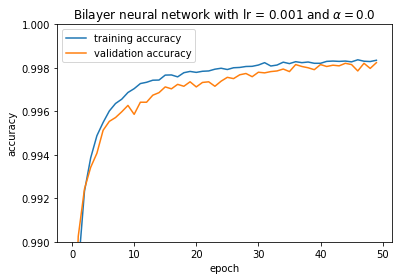

--- 35.56619191169739 seconds ---
Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.800%


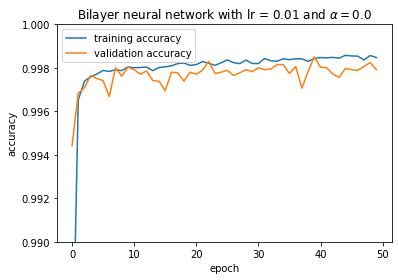

--- 72.14048910140991 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.829%


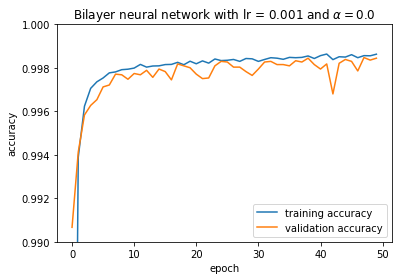

--- 116.51866102218628 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.819%


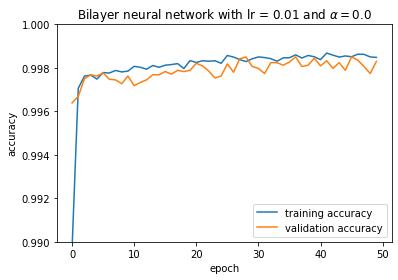

--- 162.97554421424866 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.824%


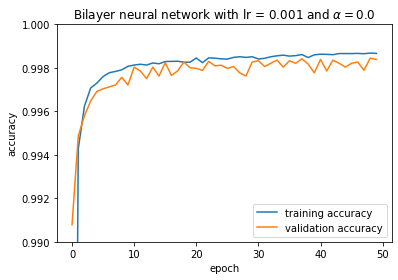

--- 215.81026792526245 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.806%


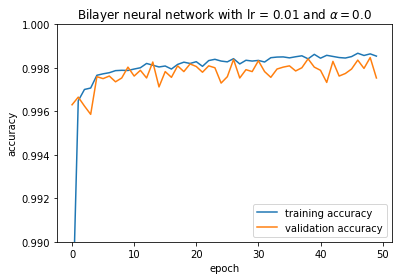

--- 267.2265679836273 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.813%


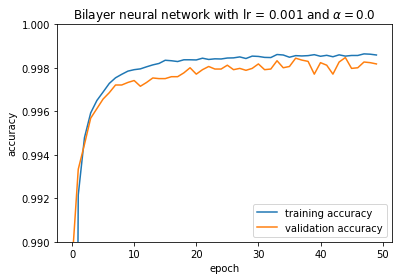

--- 308.0378749370575 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.792%


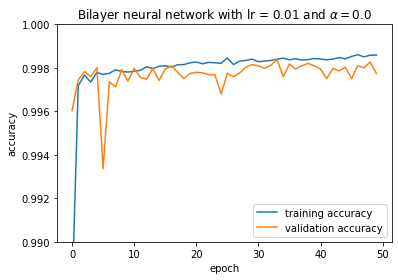

--- 350.77183389663696 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.823%


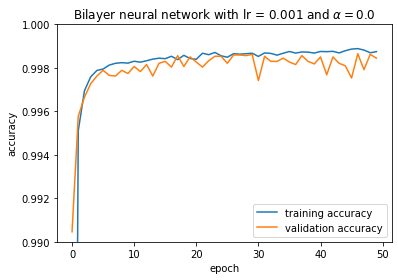

--- 403.7713940143585 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.824%


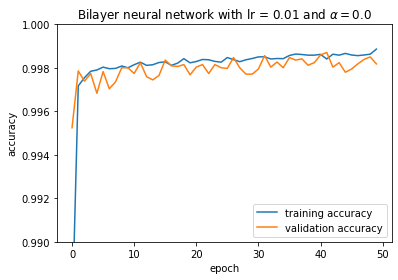

--- 455.18314814567566 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.863%


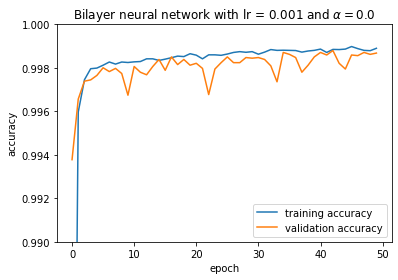

--- 508.87279891967773 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.841%


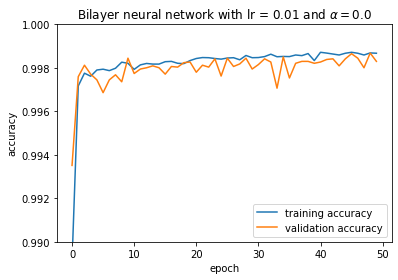

--- 563.4743769168854 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.797%


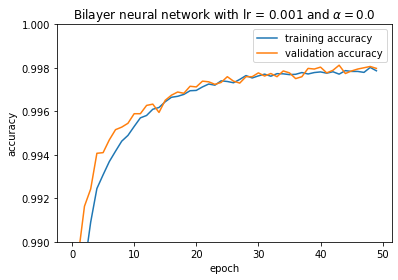

--- 622.7670631408691 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.813%


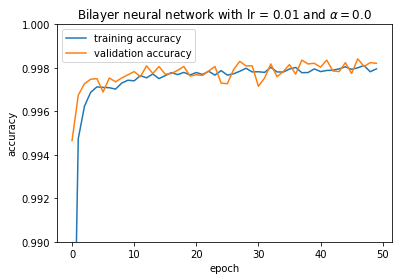

--- 684.0681059360504 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.812%


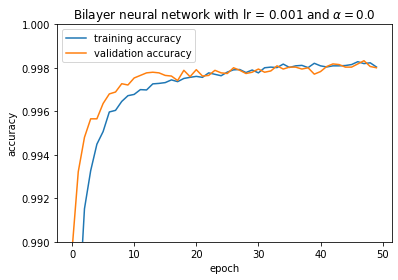

--- 752.9481749534607 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.802%


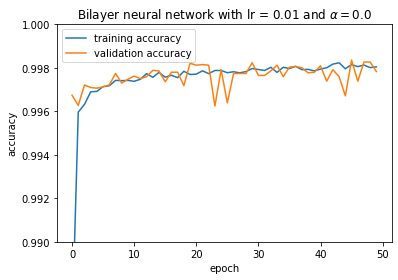

--- 823.4936850070953 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.819%


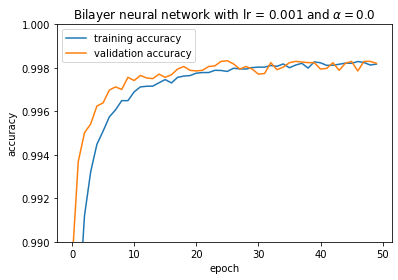

--- 898.9417970180511 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.778%


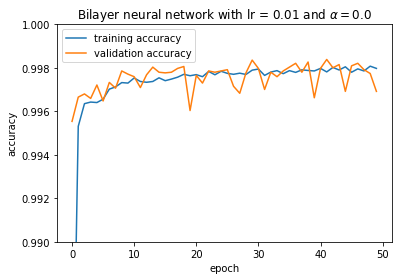

--- 971.544401884079 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.803%


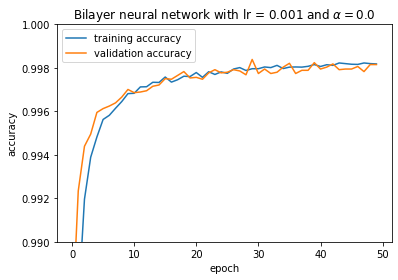

--- 1051.0371890068054 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.804%


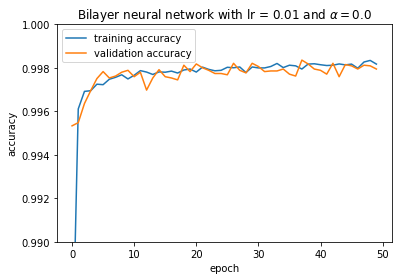

--- 1132.760162115097 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.833%


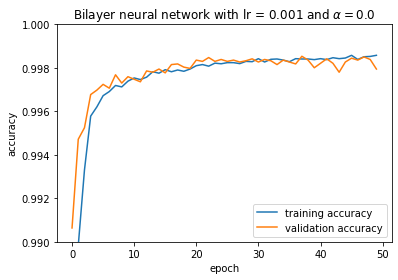

--- 1223.8933141231537 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.825%


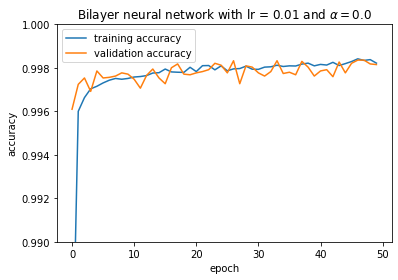

--- 1317.1392741203308 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.832%


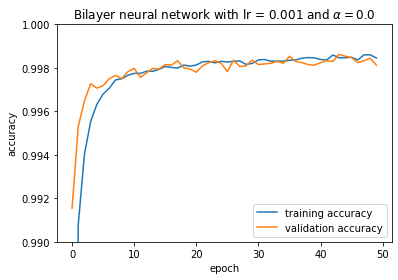

--- 1412.428550004959 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.800%


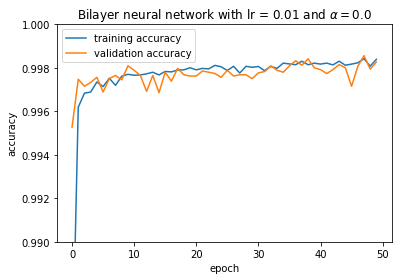

--- 1511.056718826294 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.793%


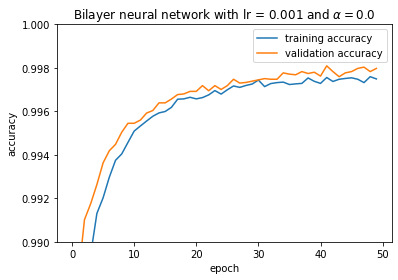

--- 1583.056100845337 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.746%


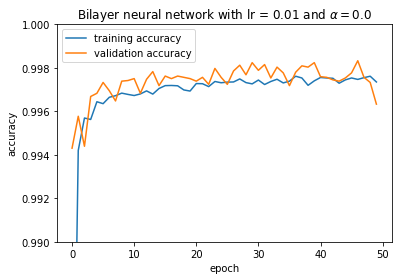

--- 1655.9185190200806 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.749%


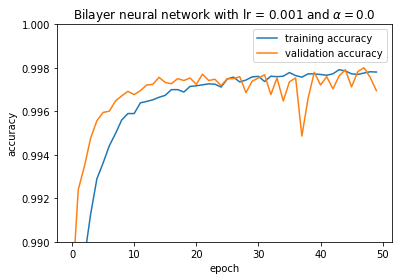

--- 1736.2472231388092 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.677%


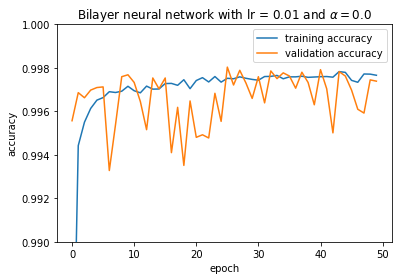

--- 1819.0369520187378 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.636%


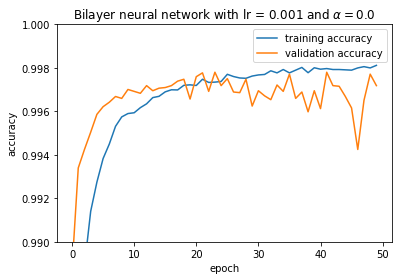

--- 1903.183701992035 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.711%


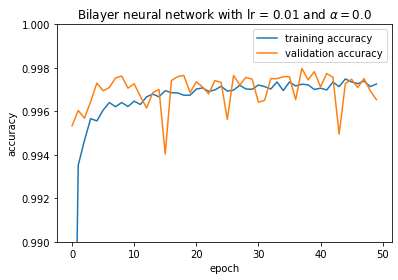

--- 1991.0742101669312 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.805%


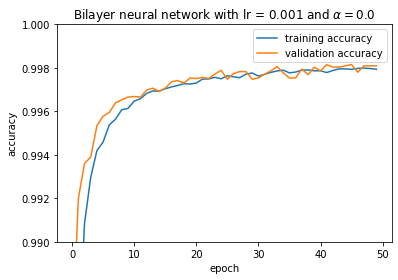

--- 2081.8412330150604 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.792%


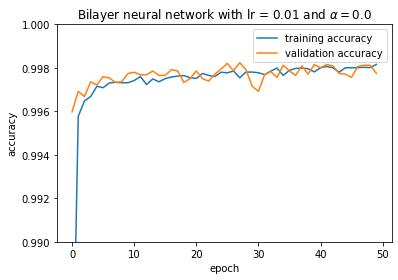

--- 2174.141765832901 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.841%


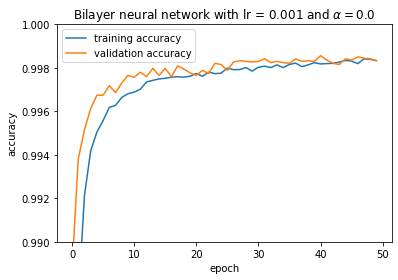

--- 2273.9033138751984 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.780%


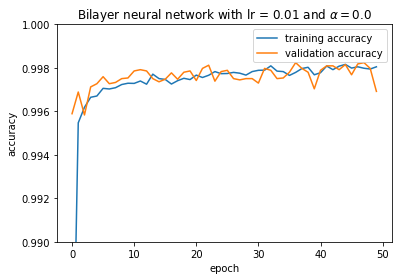

--- 2375.3619899749756 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.829%


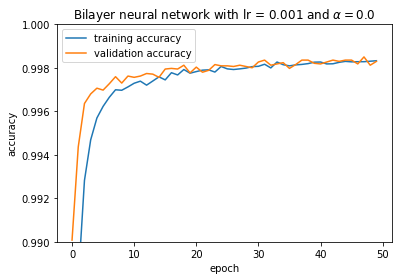

--- 2482.114641904831 seconds ---


Fitting with parameters {'class_weight': None, 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.782%


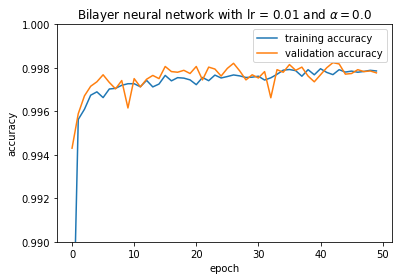

--- 2591.0939049720764 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.804%


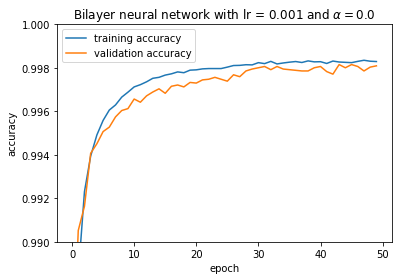

--- 2657.273684978485 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.806%


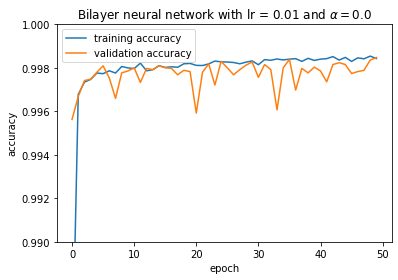

--- 2735.474147081375 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.833%


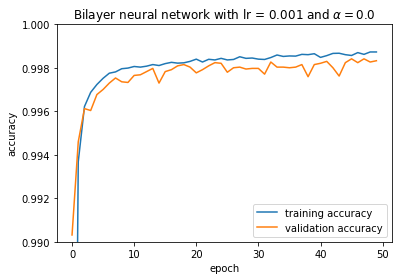

--- 2818.776041030884 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.800%


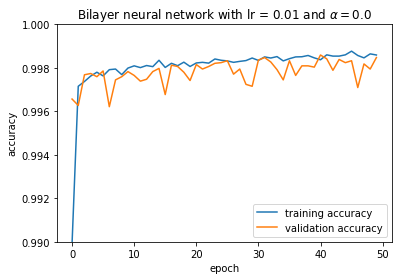

--- 2891.346781015396 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.817%


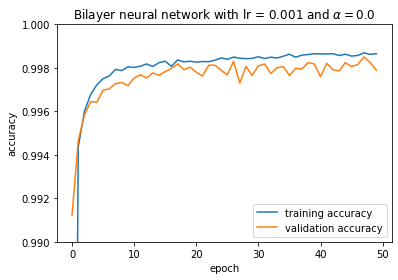

--- 2973.0016589164734 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.800%


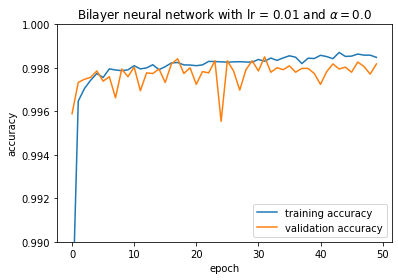

--- 3053.6312639713287 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.820%


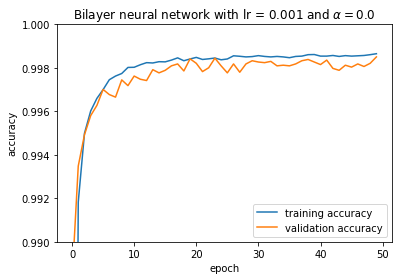

--- 3123.2008011341095 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.777%


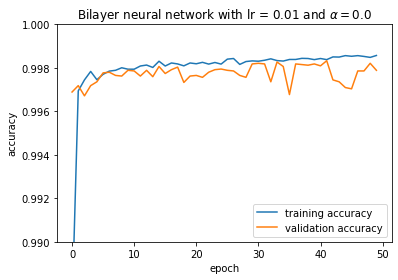

--- 3192.811215877533 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.850%


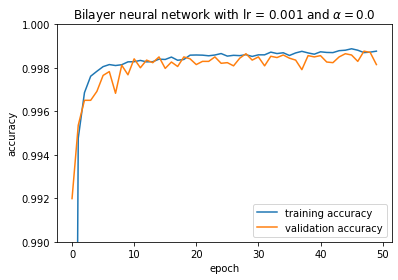

--- 3276.8517730236053 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.819%


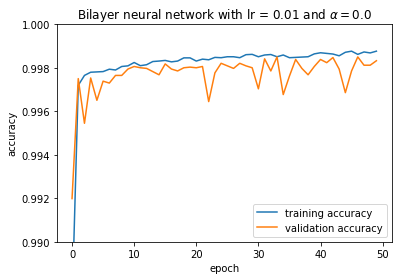

--- 3360.3668580055237 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.839%


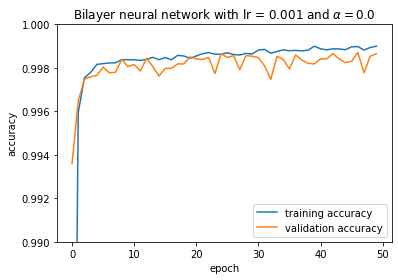

--- 3446.4563460350037 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.0, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.838%


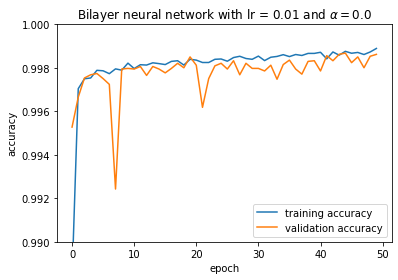

--- 3534.005865097046 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.785%


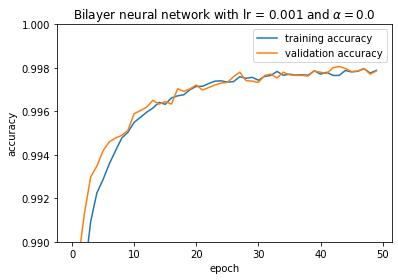

--- 3624.2601969242096 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.783%


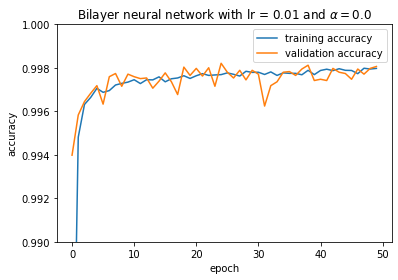

--- 3712.4154620170593 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.811%


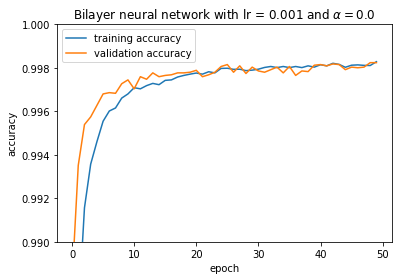

--- 3818.299747943878 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.797%


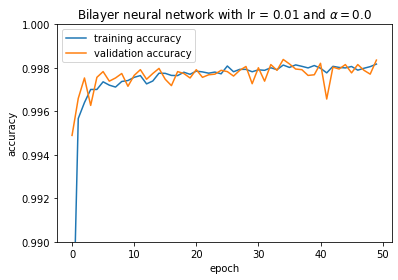

--- 3919.927339076996 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.833%


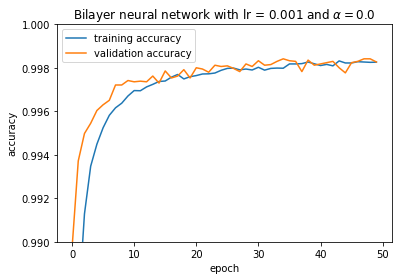

--- 4025.0148119926453 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.816%


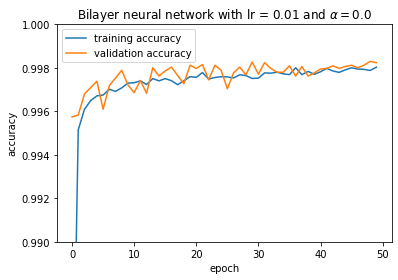

--- 4130.329437971115 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.814%


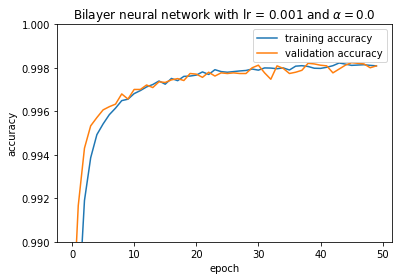

--- 4238.482285022736 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.806%


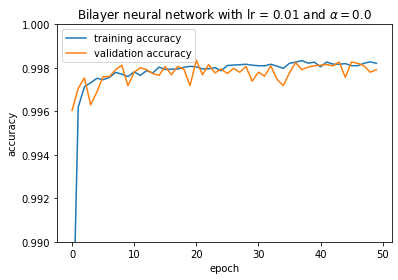

--- 4348.285702943802 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.833%


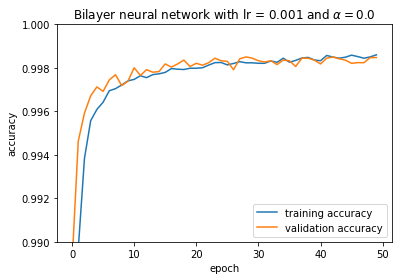

--- 4468.760675191879 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.831%


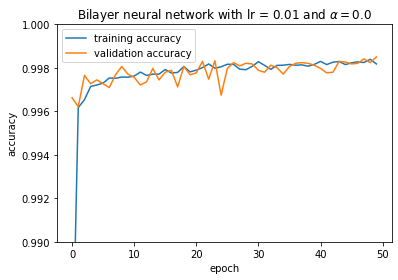

--- 4591.210597038269 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.835%


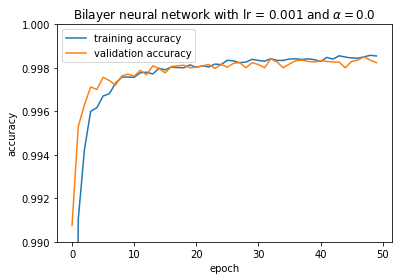

--- 4717.832506895065 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.1, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.800%


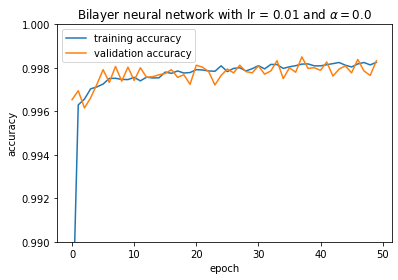

--- 4843.83772611618 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.775%


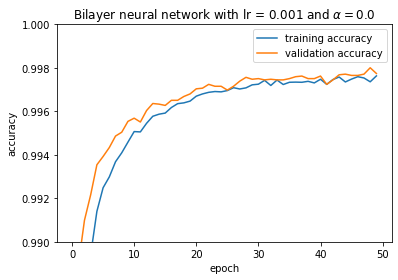

--- 4942.707417011261 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.773%


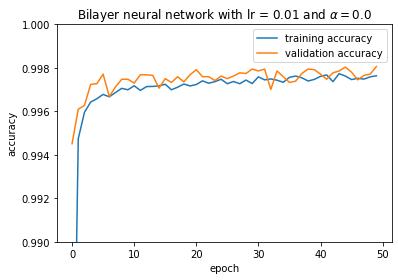

--- 5043.351826906204 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.765%


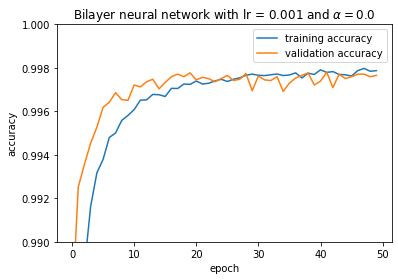

--- 5155.174491882324 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.743%


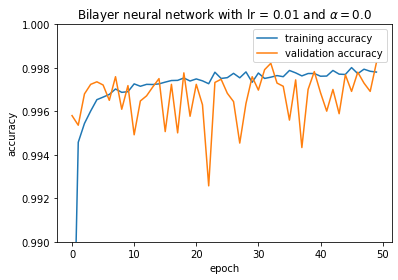

--- 5266.318766117096 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.647%


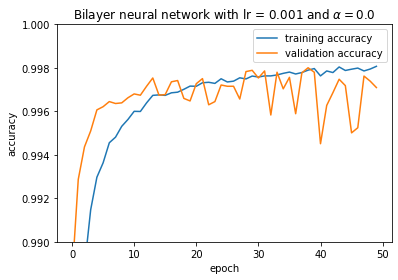

--- 5390.435875177383 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 20, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.694%


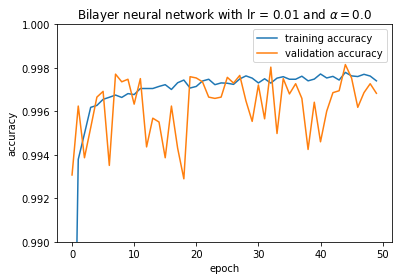

--- 5513.535760879517 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.001}


 => validation score 99.795%


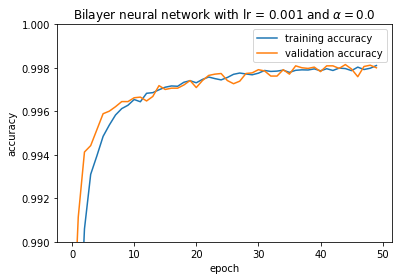

--- 5640.937847137451 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 0, 'sgd_learnrate': 0.01}


 => validation score 99.795%


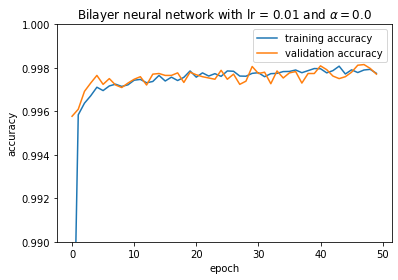

--- 5765.9658489227295 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.001}


 => validation score 99.812%


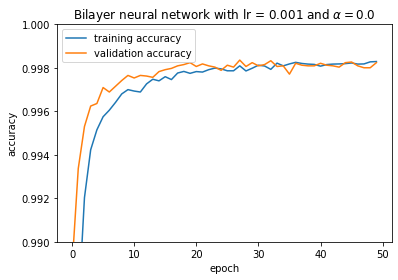

--- 5903.698893785477 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 40, 'sgd_learnrate': 0.01}


 => validation score 99.816%


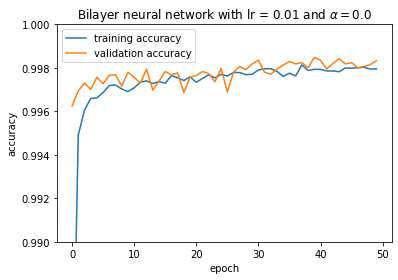

--- 6045.969300031662 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.001}


 => validation score 99.833%


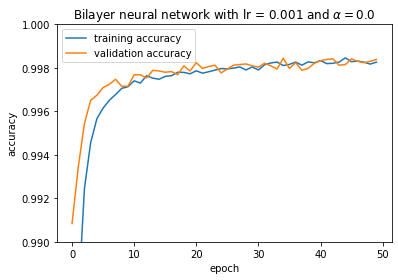

--- 6186.37159204483 seconds ---


Fitting with parameters {'class_weight': array([0.82543067, 1.26821278]), 'dropout_rate': 0.2, 'l2_alpha': 0.0, 'number_of_hidden1_layers': 40, 'number_of_hidden2_layers': 80, 'sgd_learnrate': 0.01}


 => validation score 99.776%


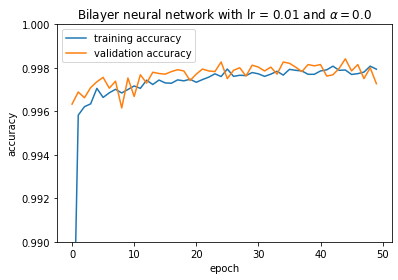

--- 6330.855744123459 seconds ---


In [9]:
from keras.utils import to_categorical
import numpy as np

import time
start_time = time.time()

# Save accuracy on test set
no_last = 5 # Take the last 5 due to the upwards shape of the curve at its end
test_scores = []

# Parameters for fitting with batches and epochs
epochs = 50
batch_size = 320 # Default batch_size = 32
# Playing around with batch sizes of [3, 30, None=32, 320, 3200] shows the effect
#  that the bigger the size, the faster the calculation performance,
#  ... the worse the convergence. => Batch size has effect of learning rate.
# 320 seems to be the perfect value.

for params_dict in grid :

    model = build_and_compile_nn(params_dict)
    
    print('Fitting with parameters', params_dict)
    # Fit the model
    history = model.fit(
        x=X_tr, y=to_categorical(y_tr),
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(X_te, to_categorical(y_te)),
        class_weight=params_dict['class_weight']
        , verbose=0
    )

    # Save accuracy on train set and validation set
    params_dict['accuracy_tr'] = np.mean(history.history['accuracy'][-no_last:])
    params_dict['accuracy_val'] = np.mean(history.history['val_accuracy'][-no_last:])
    params_dict['log_accuracy_tr'] = -np.log(1-np.mean(history.history['accuracy'][-no_last:]))
    params_dict['log_accuracy_val'] = -np.log(1-np.mean(history.history['val_accuracy'][-no_last:]))

    print(' => validation score {:.3f}%'.format(100*params_dict['accuracy_val']))
    # Save result
    test_scores.append(params_dict)
    
    plot_result(history, params_dict)
    print("--- %s seconds ---" % (time.time() - start_time))
    
# Save measured accuracies
df_test_scores_nn = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

In [10]:
pd.set_option("display.max_rows", len(grid))

pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

,class_weight,dropout_rate,l2_alpha,number_of_hidden1_layers,number_of_hidden2_layers,sgd_learnrate,accuracy_tr,accuracy_val,log_accuracy_tr,log_accuracy_val
10,None,0.0,0.0,40,80,0.001,0.998871,0.998632,6.786818,6.594511
44,"[0.8254306689603372, 1.2682127833823476]",0.0,0.0,40,40,0.001,0.998776,0.998503,6.705695,6.504296
11,None,0.0,0.0,40,80,0.010,0.998667,0.998415,6.620593,6.447129
32,None,0.2,0.0,40,40,0.001,0.998328,0.998409,6.393967,6.443428
46,"[0.8254306689603372, 1.2682127833823476]",0.0,0.0,40,80,0.001,0.998939,0.998391,6.848410,6.432429
47,"[0.8254306689603372, 1.2682127833823476]",0.0,0.0,40,80,0.010,0.998723,0.998380,6.663359,6.425148
58,"[0.8254306689603372, 1.2682127833823476]",0.1,0.0,40,80,0.001,0.998504,0.998350,6.505268,6.407190
38,"[0.8254306689603372, 1.2682127833823476]",0.0,0.0,20,40,0.001,0.998670,0.998333,6.622787,6.396580
20,None,0.1,0.0,40,40,0.001,0.998515,0.998327,6.512187,6.393061
70,"[0.8254306689603372, 1.2682127833823476]",0.2,0.0,40,80,0.001,0.998258,0.998327,6.352684,6.393061


With the DataFrame of the scoring results, the best Neural Network can be assessed. The parameters for the best classifier can be seen below and a new training process with a high number of epochs will be started.

The parameters for the best model are ...
l2_alpha = 0.0
sgd_learnrate = 0.001
dropout_rate = 0.0
class_weight = None
number_of_hidden1_layers = 40
number_of_hidden2_layers = 80


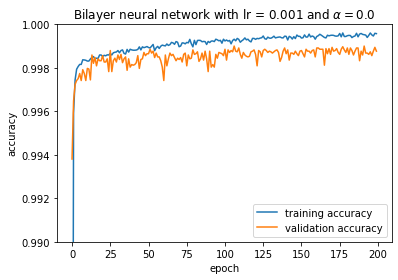

In [11]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

model_best = build_and_compile_nn(best_params)

# Check Model configuration
model_best.get_config()

# Parameters for fitting with batches and epochs
epochs = 200
batch_size = 320

# Fit the model
history_best = model_best.fit(
    x=X_tr, y=to_categorical(y_tr),
    batch_size=batch_size, epochs=epochs,
    validation_data=(X_te, to_categorical(y_te))
    , verbose=0
)

plot_result(history_best, best_params)

The accuracy scores of the last $\texttt{no}\_\texttt{last}$ validation measurements shall be printed for the best long run trained Neural Network.

In [12]:
no_last = 5 # I take the last 5 due to the upwards shape of the curve at its end

print('Mean last {:d} validation accuracy : {:.3f}%'.format(
    no_last, 100*np.mean(history_best.history['val_accuracy'][-no_last:])
))

print('Neural network accuracy (test set): {:.3f}%'.format(
    100*model.evaluate(X_te, to_categorical(y_te),
                   verbose=0)[1] # Loss is at index=0, accuracy at index=1
))

Mean last 5 validation accuracy : 99.876%


Neural network accuracy (test set): 99.727%


The architecture of the best model is shown in the following output cell.

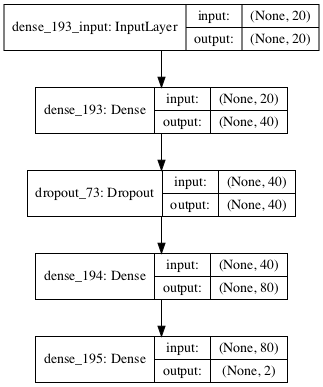

In [13]:
from keras.utils import plot_model

path_model_graphics = './documentation'
model_png = os.path.join(path_model_graphics,'model.png')

plot_model(model_best, show_shapes=True, dpi=72, to_file=model_png)

### General Observations

For the models trained above, some general observations can be expressed.
- The validation curves in the plots above lay below the training curves. This is an indicator of a valid model behaviour.
- The curves of the validation accuracy above show the behaviour of approaching their constant maximum value only very slowly. A very high number of epochs is needed to reach the maximum value of the validation accuracy. Some simulation have been done in the course of the project with a number of epochs of 500. Even with this high number of epochs, there could still be seen a slight slope in the validation accurace, indicating that the model was still learning and improving. The validation accuracy has never surpassed a value of 99.93%, though. The latter observation led to the conviction that the accuracy of the model would not be increased significantly, increasing the number of epochs even to a value higher than 500.
- Although the best estimator model has an architecture with a second hidden layer, one hidden layer is sufficient. Adding a second hidden layer to the Neural Network does not raise the quality of the model essentially.

### Performance Measurement

The performance measurement of the best model has been described in chapter [Decision Tree Model](./6_DecisionTreeModel.ipynb) and is shown without any further comment.

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = model_best.predict_classes(X_te)

confusion_matrix(y_te, y_pred)

array([[20615,    21],
       [   21, 13411]])

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from keras.metrics import accuracy

# .score() function of sklearn models results in the same value as .accuracy_score() function of sklearn.metrics.
#  Keras library does not offer any .score() function but only .evaluate().
#  Is second metric of .evaluate(X_te, y_te) == .accuracy_score(y_te, y_pred)? <= See the output.
print('Score {:.3f}%'.format(100*model_best.evaluate(x=X_te, y=to_categorical(y_te))[1]))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(100*roc_auc_score(y_te, y_pred),
                100*accuracy_score(y_te, y_pred),
                100*precision_score(y_te, y_pred),
                100*recall_score(y_te, y_pred)
               ))

   32/34068 [..............................] - ETA: 2s

  768/34068 [..............................] - ETA: 2s

 1536/34068 [>.............................] - ETA: 2s

 2240/34068 [>.............................] - ETA: 2s

 2976/34068 [=>............................] - ETA: 2s

 3552/34068 [==>...........................] - ETA: 2s

 4288/34068 [==>...........................] - ETA: 2s

 4992/34068 [===>..........................] - ETA: 2s

 5760/34068 [====>.........................] - ETA: 2s

 6528/34068 [====>.........................] - ETA: 1s

 7296/34068 [=====>........................] - ETA: 1s

 8064/34068 [======>.......................] - ETA: 1s

 8832/34068 [======>.......................] - ETA: 1s

 9568/34068 [=======>......................] - ETA: 1s

10336/34068 [========>.....................] - ETA: 1s

11072/34068 [========>.....................] - ETA: 1s

11840/34068 [=========>....................] - ETA: 1s

12608/34068 [==========>...................] - ETA: 1s

13376/34068 [==========>...................] - ETA: 1s

14144/34068 [===========>..................] - ETA: 1s

14912/34068 [============>.................] - ETA: 1s

15648/34068 [============>.................] - ETA: 1s

16416/34068 [=============>................] - ETA: 1s

17152/34068 [==============>...............] - ETA: 1s

17920/34068 [==============>...............] - ETA: 1s

18656/34068 [===============>..............] - ETA: 1s

19424/34068 [================>.............] - ETA: 1s

20192/34068 [================>.............] - ETA: 0s

20960/34068 [=================>............] - ETA: 0s

21728/34068 [==================>...........] - ETA: 0s

22496/34068 [==================>...........] - ETA: 0s

23232/34068 [===================>..........] - ETA: 0s

24000/34068 [====================>.........] - ETA: 0s

24768/34068 [====================>.........] - ETA: 0s

25472/34068 [=====================>........] - ETA: 0s

26208/34068 [======================>.......] - ETA: 0s

26944/34068 [======================>.......] - ETA: 0s

27712/34068 [=======================>......] - ETA: 0s

28448/34068 [========================>.....] - ETA: 0s

29184/34068 [========================>.....] - ETA: 0s

29920/34068 [=========================>....] - ETA: 0s

30688/34068 [==========================>...] - ETA: 0s

31424/34068 [==========================>...] - ETA: 0s

32160/34068 [===========================>..] - ETA: 0s

32928/34068 [===========================>..] - ETA: 0s

33664/34068 [============================>.] - ETA: 0s

34068/34068 [==============================] - 2s 69us/step


Score 99.877%


Area under the curve 99.871% - accuracy 99.877% - precision 99.844% - recall 99.844%


The wrongly classified records still have to be stored for model comparison in the summary chapter.

In [16]:
import results_analysis_funcs as raf
import results_saving_funcs as rsf

idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              model_best, i, df_attribute_with_sim_feature.iloc[idx_te].iloc[idx[i]])

## Summary

The code of this chapter searches the best Neural Network model for Swissbib's training data. As the resulting score of an estimator with one single hidden layer has remained below the score of the models of the precedent chapters, estimators with more interaction, forced by a second hidden layer has been tried. The result improvement with this second layer has not been essential, thowgh.

## Results Handover

This chapter contributes with the result of one model to the model assessment ranking of chapter [Overview and Summary](./0_OverviewSummary.ipynb).

In [17]:
path_results = './results'

rsf.add_result_to_results(path_results, df_test_scores_nn, model_best, X_te, y_te, y_pred)